Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


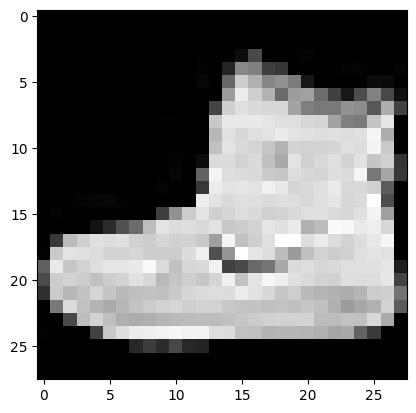

Label: 9


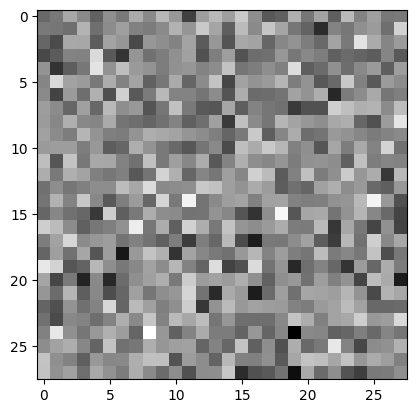

Saving fake_images-0000.png
Epoch [0/10], Step [500/6000], d_loss: 0.0741, g_loss: 3.3338, D(x): 0.96, D(G(z)): 0.03
Epoch [0/10], Step [1000/6000], d_loss: 0.2842, g_loss: 4.5711, D(x): 0.85, D(G(z)): 0.04
Epoch [0/10], Step [1500/6000], d_loss: 0.5549, g_loss: 1.4304, D(x): 0.94, D(G(z)): 0.34
Epoch [0/10], Step [2000/6000], d_loss: 1.4175, g_loss: 1.2475, D(x): 0.50, D(G(z)): 0.33
Epoch [0/10], Step [2500/6000], d_loss: 0.2913, g_loss: 2.8979, D(x): 0.89, D(G(z)): 0.13
Epoch [0/10], Step [3000/6000], d_loss: 0.2609, g_loss: 2.7528, D(x): 0.88, D(G(z)): 0.07
Epoch [0/10], Step [3500/6000], d_loss: 0.5353, g_loss: 2.1545, D(x): 0.87, D(G(z)): 0.29
Epoch [0/10], Step [4000/6000], d_loss: 0.6513, g_loss: 3.2714, D(x): 0.70, D(G(z)): 0.17
Epoch [0/10], Step [4500/6000], d_loss: 0.8773, g_loss: 1.7888, D(x): 0.64, D(G(z)): 0.15
Epoch [0/10], Step [5000/6000], d_loss: 0.6708, g_loss: 2.6214, D(x): 0.81, D(G(z)): 0.21
Epoch [0/10], Step [5500/6000], d_loss: 0.7989, g_loss: 1.8371, D(x): 0.8

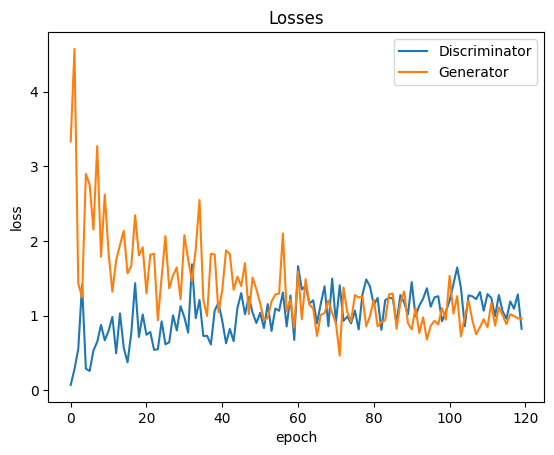

In [4]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

img, label = fashion_mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])

import matplotlib.pyplot as plt
# %matplotlib inline

plt.imshow(img[0], cmap='gray')
plt.show()
print('Label:', label)

from torch.utils.data import DataLoader

batch_size = 10 #change to smaller batch size
data_loader = DataLoader(fashion_mnist, batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 784
hidden_size = 256
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device)

latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.PReLU(), #change to PReLu
    nn.Linear(hidden_size, hidden_size),
    nn.PReLU(), #change to PReLu
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

y = G(torch.randn(2, latent_size))
gen_imgs = y.reshape((-1, 28,28)).detach()
plt.imshow(gen_imgs[0], cmap='gray')
plt.show()

G.to(device)

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002) #smaller learning rate
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)


from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(images, os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(fake_images, os.path.join(sample_dir, fake_fname), nrow=10)

save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

num_epochs = 10 # smaller epoch size
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 500 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    if (epoch+1) % 5 == 0:
        save_fake_images(epoch+1)


Image('./samples/fake_images-0050.png')
Image('./samples/fake_images-0100.png')
Image('./samples/fake_images-0300.png')

plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses')
plt.show()